<a href="https://colab.research.google.com/github/MrBigBrane/Machine-Learning/blob/main/MNIST_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset

# for getting summary info on models
from torchsummary import summary

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [ ]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Load and Split

In [ ]:
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

labels = train['label']
train.drop('label',axis=1,inplace=True)

ids = test.index.tolist()
ids = [i+1 for i in ids]

In [ ]:
train_data,test_data, train_labels,test_labels = train_test_split(train, labels, test_size=.1)

## Data Augmentation

In [ ]:
class MNISTDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data.iloc[idx].values.reshape(28, 28)
        label = None
        if self.labels is not None:
            label = self.labels.iloc[idx]
        if self.transform:
          image = self.transform(image)
        if label is None:
          return image
        else:
          return image, label

In [ ]:
class AddGaussianNoise:
    def __init__(self, mean=0.0, std=1.0):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        noise = torch.randn(tensor.size()) * self.std + self.mean
        return tensor + noise

In [ ]:
# Instantiate train dataset with transforms
train_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.astype(np.uint8)),
    transforms.ToPILImage(),
    # transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    AddGaussianNoise(mean=0.0, std=0.1),
    transforms.Normalize(mean=[0.5], std=[0.5])  # For grayscale images
])

mnist_data = MNISTDataset(data=train, labels=labels, transform=train_transform)

In [ ]:
test_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.astype(np.uint8)),
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # For grayscale images
])

validation_data = MNISTDataset(data=test_data, labels=test_labels, transform=test_transform)
evaluation_data = MNISTDataset(data=test, labels=None, transform=test_transform)

## Data Processing and Investigation

In [ ]:
batchsize    = 32
train_loader = DataLoader(mnist_data,batch_size=batchsize,shuffle=True,drop_last=True)
validation_loader  = DataLoader(validation_data,batch_size=validation_data.data.shape[0])

test_loader = DataLoader(evaluation_data,batch_size=evaluation_data.data.shape[0])

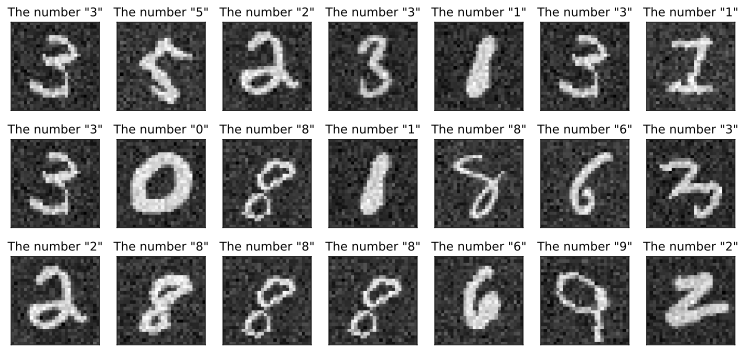

In [ ]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(13,6))
X, y = next(iter(train_loader))

for i,ax in enumerate(axs.flatten()):

  # pick a random pic
  whichpic = np.random.randint(X.shape[0])

  # extract the image and its target letter
  I = np.squeeze( X[whichpic, :, :, :] )
  number = np.sort(labels.unique())[y[whichpic]]

  # visualize
  ax.imshow(I,cmap='gray')
  ax.set_title('The number "%s"'%number)
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

## CNN Architecture

In [ ]:
# create a class for the model
def makeTheNet(printtoggle=False):

  class mnistnet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      # print toggle
      self.print = printtoggle

      ### -------------- feature map layers -------------- ###
      # first convolution layer
      self.conv1  = nn.Conv2d(1,32,3,padding=1)
      self.bnorm1 = nn.BatchNorm2d(32) # input the number of channels in this layer
      # output size: (28+2*1-3)/1 + 1 = 28/2 = 14 (/2 b/c maxpool)

      # second convolution layer
      self.conv2  = nn.Conv2d(32,64,3,padding=1)
      self.bnorm2 = nn.BatchNorm2d(64) # input the number of channels in this layer
      # output size: (14+2*1-3)/1 + 1 = 14/2 = 7 (/2 b/c maxpool)

      # third convolution layer
      self.conv3  = nn.Conv2d(64,64,3,padding=1)
      self.bnorm3 = nn.BatchNorm2d(64) # input the number of channels in this layer
      # output size: (7+2*1-3)/1 + 1 = 7/2 = 3 (/2 b/c maxpool)

      # fourth convolution layer
      self.conv4  = nn.Conv2d(64,128,3,padding=1)
      self.bnorm4 = nn.BatchNorm2d(128) # input the number of channels in this layer
      # output size: (3+2*1-3)/1 + 1 = 3/2 = 1 (/2 b/c maxpool)


      ### -------------- linear decision layers -------------- ###
      self.fc1 = nn.Linear(1*1*128,512)
      self.fc2 = nn.Linear(512, 10)

    def forward(self,x):

      if self.print: print(f'Input: {list(x.shape)}')

      # first block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv1(x),2)
      x = F.leaky_relu(self.bnorm1(x))
      if self.print: print(f'First CPR block: {list(x.shape)}')

      # second block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv2(x),2)
      x = F.leaky_relu(self.bnorm2(x))
      if self.print: print(f'Second CPR block: {list(x.shape)}')

      # third block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv3(x),2)
      x = F.leaky_relu(self.bnorm3(x))
      if self.print: print(f'Third CPR block: {list(x.shape)}')

      # fourth block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv4(x),2)
      x = F.leaky_relu(self.bnorm4(x))
      if self.print: print(f'Fourth CPR block: {list(x.shape)}')


      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Vectorized: {list(x.shape)}')

      # linear layers
      x = F.leaky_relu(self.fc1(x))
      x = self.fc2(x)
      if self.print: print(f'Final output: {list(x.shape)}')

      return x

  # create the model instance
  net = mnistnet(printtoggle)

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.00001,weight_decay=5e-3)

  return net,lossfun,optimizer

In [ ]:
X, y = next(iter(train_loader))
net,lossfun,optimizer = makeTheNet(printtoggle=True)
yTest = net(X)

Input: [32, 1, 28, 28]
First CPR block: [32, 32, 14, 14]
Second CPR block: [32, 64, 7, 7]
Third CPR block: [32, 64, 3, 3]
Fourth CPR block: [32, 128, 1, 1]
Vectorized: [32, 128]
Final output: [32, 10]


## Training

In [ ]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 50

  # create a new model
  net,lossfun,optimizer = makeTheNet()

  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)
  trainErr  = torch.zeros(numepochs)
  testErr   = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train()
    batchLoss = []
    batchErr  = []
    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and error from this batch
      batchLoss.append(loss.item())
      batchErr.append( torch.mean((torch.argmax(yHat,axis=1) != y).float()).item() )
    # end of batch loop...

    # and get average losses and error rates across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainErr[epochi]  = 100*np.mean(batchErr)



    ### test performance
    net.eval()
    X,y = next(iter(validation_loader)) # extract X,y from test dataloader

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      loss = lossfun(yHat,y)

    # get loss and error rate from the test batch
    testLoss[epochi] = loss.item()
    testErr[epochi]  = 100*torch.mean((torch.argmax(yHat,axis=1) != y).float()).item()

  # end epochs

  # function output
  return trainLoss,testLoss,trainErr,testErr,net

In [ ]:
trainLoss,testLoss,trainErr,testErr,net = function2trainTheModel()

## Results

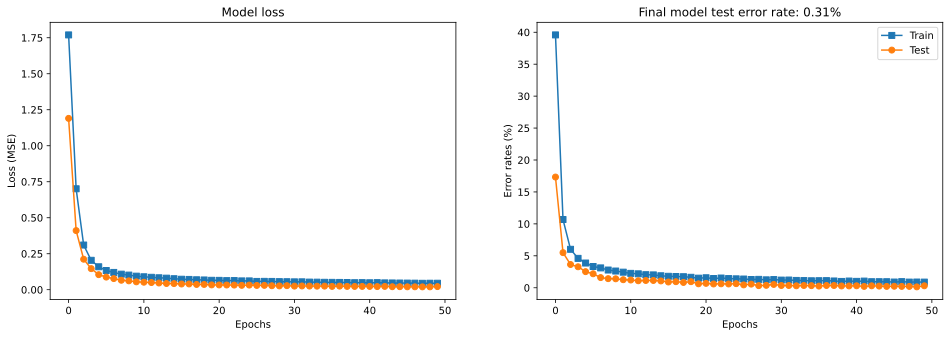

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainErr,'s-',label='Train')
ax[1].plot(testErr,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error rates (%)')
ax[1].set_title(f'Final model test error rate: {testErr[-1]:.2f}%')
ax[1].legend()

plt.show()

## Post Training Analysis

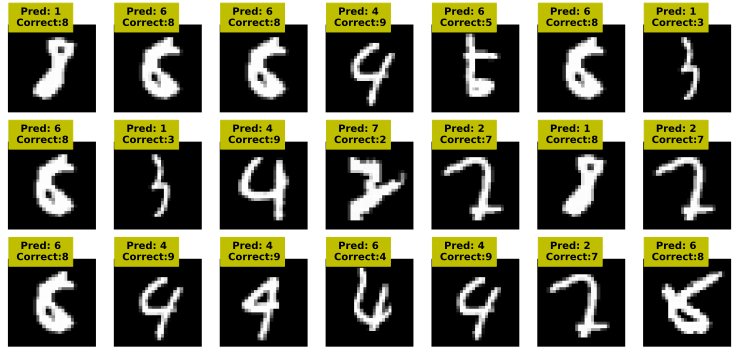

In [ ]:
# visualize some images
net.eval() # switch to test mode
X,y = next(iter(validation_loader))

# push data to GPU
X = X.to(device)
y = y.to(device)

# forward pass and loss
with torch.no_grad():
  yHat = net(X)

yHat = torch.argmax(yHat,axis=1)
incorrectPred = (yHat != y)
incorrectX = X[incorrectPred,:,:]
incorrectY = y[incorrectPred]
incorrectYHat = yHat[incorrectPred]

fig,axs = plt.subplots(3,7,figsize=(13,6))

for i,ax in enumerate(axs.flatten()):

  # pick a random pic
  whichpic = np.random.randint(incorrectX.shape[0])

  # extract the image and its target letter
  I = np.squeeze( incorrectX[whichpic,:,:] ).cpu().numpy()
  predNum = np.sort(labels.unique())[incorrectYHat[whichpic]]
  correctNum  = np.sort(labels.unique())[incorrectY[whichpic]]

  # visualize
  ax.imshow(I,cmap='gray')
  # ax.set_title('The letter "%s"'%clothingItem)
  ax.text(10,0,"Pred: " + str(predNum) + "\n Correct:" + str(correctNum),ha='center',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

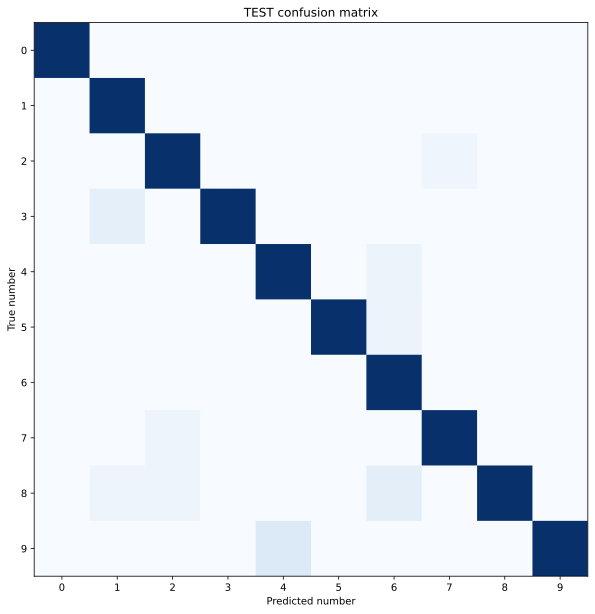

In [ ]:
import sklearn.metrics as skm

net.eval()
with torch.no_grad():
  yHat = net(X)


# compute the confusion matrix
C = skm.confusion_matrix(y.cpu(),torch.argmax(yHat.cpu(),axis=1), normalize='true')

# visualize it
fig = plt.figure(figsize=(10,10))
plt.imshow(C,'Blues',vmax=.05)

# make the plot look nicer
plt.xticks(range(10),labels=np.sort(labels.unique()))
plt.yticks(range(10),labels=np.sort(labels.unique()))
plt.title('TEST confusion matrix')
plt.xlabel('True number')
plt.xlabel('Predicted number')
plt.ylabel('True number')

plt.show()

## Submission

In [ ]:
X = next(iter(test_loader))

X = X.to(device)

net.eval()
with torch.no_grad():
    submission_pred = net(X)
    submission_pred = torch.argmax(submission_pred,axis=1)

print(submission_pred)

tensor([2, 0, 9,  ..., 3, 9, 2], device='cuda:0')


In [ ]:
ans=pd.DataFrame({'ImageId':ids,'Label': submission_pred.cpu()})
ans.to_csv('submission.csv',index=False)